**Conociento ML**

2. **Clustering:** Para esta sección se usará el archivo `data_eda_clustering.csv` que contiene datos de vulnerabilidades comunes de diferentes sistemas operativos.

    **Información del dataset**
    - 1 Variables
    - mod_date
    - pub_date
    - cvss
    - cwe_code
    - cwe_name
    - summary
    - access_authentication
    - access_complexity
    - access_vector
    - impact_availability
    - impact_confidentiality
    - impact_integrity
    - vulnerable_product
    - vendor
    
El objetivo de este ejercicio es encontrar subconjuntos dentro del conjunto de datos original usando técnicas de clustering. Justifica la elección de un modelo con métricas adecuadas para esta tarea y si es posible su optimización.

# **Solucion**
Como primer paso hagamos un análisis exploratorio de los datos y veamos cuáles serán nuestras columnas candidatas a `features` o caracteristicas. Como el objetivo de nuestro problema es agrupar los datos en `clusters` o grupos y no se dispone aún de un conjunto de clusters para validar estamos ante un proceso de `aprendizaje no supervizado`. El objetivo es entonces crear esta nueva columna llamada `clusters` que contenga los grupos.

#### **Análisis Exploratorio de los Datos**

In [2]:
# instalacion de la libreria kmodes
!pip install kmodes

In [3]:
# Importemos las librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from kmodes.kmodes import KModes
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes

Como se verá más adelante disponemos para este proyecto una categoría muy importante de tipo numérica y otras categorias nominales por lo que `Kmeans` (solo se usa para datos de caracteristicas numéricas) y `Kmodes`(solo se usa para datos de categorias nominales u ordinales) no nos servirán en este trabajo y en su lugar, invocaremos `kprototypes` que nos permite trabajar con ambos conjuntos de datos, es decir, tanto numéricos como categóricos.

In [4]:
# guardemos los datos en un dataframe de pandas
df = pd.read_csv('data_eda_clustering.csv')

In [5]:
# veamos la informacion almacenada
df.head(3)

,Unnamed: 0,mod_date,pub_date,cvss,cwe_code,cwe_name,summary,access_authentication,access_complexity,access_vector,impact_availability,impact_confidentiality,impact_integrity,vulnerable_product,vendor
0,CVE-1999-0001,2010-12-16 05:00:00,1999-12-30 05:00:00,5.0,20,Improper Input Validation,ip_input.c in BSD-derived TCP/IP implementatio...,NONE,LOW,NETWORK,PARTIAL,NONE,NONE,bsd_os,bsdi
1,CVE-1999-0001,2010-12-16 05:00:00,1999-12-30 05:00:00,5.0,20,Improper Input Validation,ip_input.c in BSD-derived TCP/IP implementatio...,NONE,LOW,NETWORK,PARTIAL,NONE,NONE,bsd_os,freebsd
2,CVE-1999-0001,2010-12-16 05:00:00,1999-12-30 05:00:00,5.0,20,Improper Input Validation,ip_input.c in BSD-derived TCP/IP implementatio...,NONE,LOW,NETWORK,PARTIAL,NONE,NONE,bsd_os,openbsd


In [6]:
#informacion del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251380 entries, 0 to 251379
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              251380 non-null  object 
 1   mod_date                251380 non-null  object 
 2   pub_date                251380 non-null  object 
 3   cvss                    251380 non-null  float64
 4   cwe_code                251380 non-null  int64  
 5   cwe_name                251380 non-null  object 
 6   summary                 251380 non-null  object 
 7   access_authentication   242004 non-null  object 
 8   access_complexity       242004 non-null  object 
 9   access_vector           242004 non-null  object 
 10  impact_availability     242004 non-null  object 
 11  impact_confidentiality  242004 non-null  object 
 12  impact_integrity        242004 non-null  object 
 13  vulnerable_product      251338 non-null  object 
 14  vendor              

Este conjunto de datos tiene 251380 registros y 15 columnas

*Contexto con las variables estadísticas*

    - 1 Variables: En esta columna encontramos un identificador que nos dice que la vulnerabilidad fue registrada en el año 1999 y probablemente el 0001 sea un indicador que dice que es la primera vulnerabilidad de este tipo reistrada

    - mod_date: Esta fecha parece indicar una modificación en el registro de la vulnerabilidad

    - pub_date: Esta fecha parece indicar la fecha en la que fue publicada la vulnerabilidad

    - cvss: Es un puntaje numérico conocido como el Common Vulnerability Scoring System que generalmente lo codifican en un rango entre 0 y 10, donde 10 habla de una vulnerabilidad de alto riesgo

    - cwe_code: Este código habla de una categoría específica de vulnerabilidad registrada en Common Weakness Enumeration Code

    - cwe_name: Estas etiquetas hablan del detalle del tipo de vulnerabilidad y cada código está relacionado con una única descripción

    - summary: Parece ser una breve descripción de la vulnerabilidad

    - access_authentication: Describe características de la vulnerabilidad

    - access_complexity: Describe características de la vulnerabilidad

    - access_vector: Describe características de la vulnerabilidad

    - impact_availability: Habla del impacto de la vulnerabilidad en el sistema

    - impact_confidentiality: Habla del impacto de la confidencialidad en el sistema

    - impact_integrity: Habla del impacto de la integridad en el sistema

    - vulnerable_product: Productos afectados por la vulnerabilidad
    
    - vendor: Puede ser el proveedor relacionado con los productos vulnerables

Para crear los clusters `cvss` parece ser una buena candidata, veamos su distribución

<Axes: xlabel='cvss', ylabel='Count'>

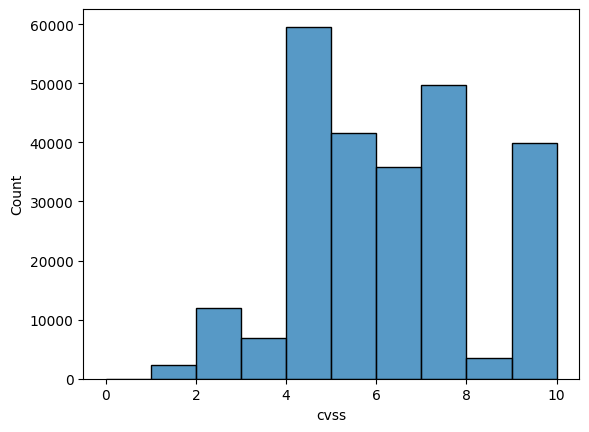

In [7]:
sns.histplot(data = df , x = 'cvss',bins=10)

In [8]:
nulos = df['cvss'].isnull().sum()
faltantes = df['cvss'].isna().sum()

print('cantidad de nulos: ', nulos)
print('cantidad de faltantes: ', faltantes)

cantidad de nulos:  0
cantidad de faltantes:  0


Los datos están muy distribuidos y no hay valores nulos ni faltantes lo que nos permitirá crear buenos clusters con esta variable. las columnas como summary, vulnerable product y vendor se descartarán por la gran cantidad de categorias que obtendriamos con estas. analicemos las demás

In [9]:
df['access_authentication'].unique()

array(['NONE', 'SINGLE', nan, 'MULTIPLE'], dtype=object)

`Acces_authentication` tiene pocas categorias

<Axes: xlabel='access_authentication', ylabel='count'>

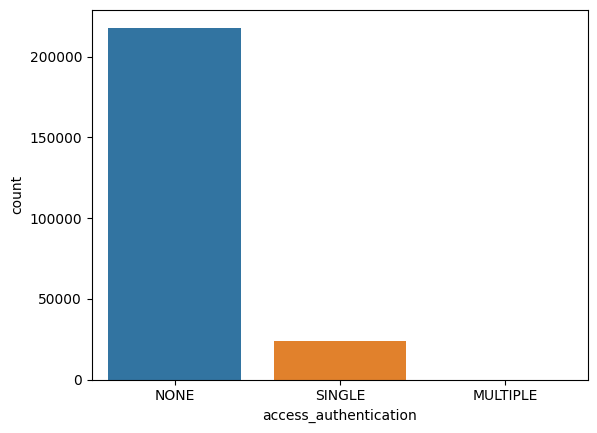

In [10]:
sns.countplot(data = df, x = 'access_authentication')

In [11]:
df['access_authentication'].value_counts()

NONE        218102
SINGLE       23871
MULTIPLE        31
Name: access_authentication, dtype: int64

In [12]:
print(f'Porcentaje NONE: {round((218102/251380)*100,2)} %')

Porcentaje NONE: 86.76 %


El 86,76% de los datos se encuentran en NONE, por lo que descartaremos esta columna pues casi todos los datos están en este estado categórico

In [13]:
df['access_complexity'].unique()

array(['LOW', 'HIGH', 'MEDIUM', nan], dtype=object)

Columna con pocas categorías

<Axes: xlabel='access_complexity', ylabel='count'>

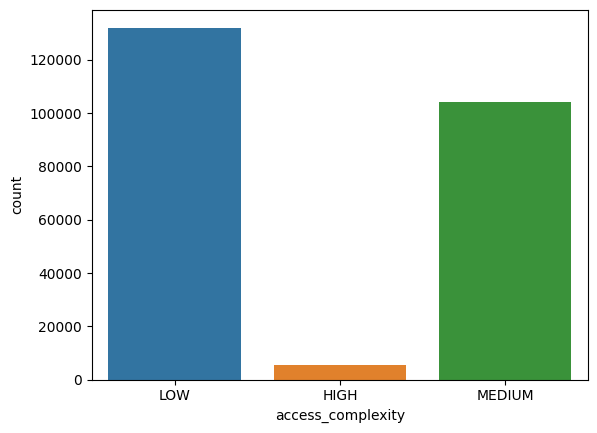

In [14]:
sns.countplot(data = df, x = 'access_complexity')

Esta columna también puede ser una buena candidata para encontrar clusters aunque no tenga tantos datos en estado HIGH

In [15]:
df['access_complexity'].value_counts()

LOW       132090
MEDIUM    104293
HIGH        5621
Name: access_complexity, dtype: int64

In [16]:
nulos = df['access_complexity'].isnull().sum()
faltantes = df['access_complexity'].isna().sum()

print('cantidad de nulos: ', nulos)
print('cantidad de faltantes: ', faltantes)

cantidad de nulos:  9376
cantidad de faltantes:  9376


Hay 9376 valores nulos con los que tenemos que crear una estrategia para rellenar

In [17]:
df['access_vector'].unique()

array(['NETWORK', 'LOCAL', 'ADJACENT_NETWORK', nan], dtype=object)

Columna access_vector con pocas categorias

<Axes: xlabel='access_vector', ylabel='count'>

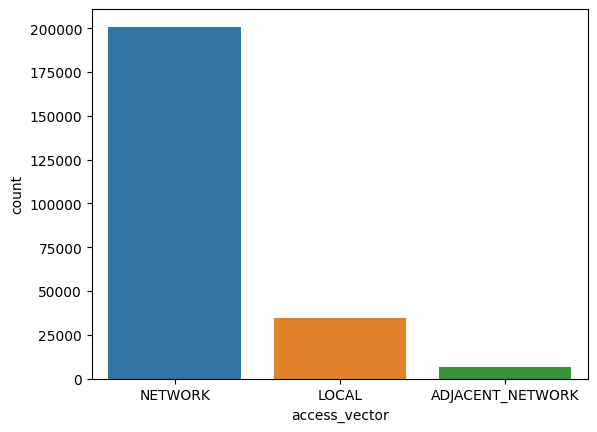

In [18]:
sns.countplot(data = df, x = 'access_vector')

In [19]:
df['access_vector'].value_counts()

NETWORK             200800
LOCAL                34590
ADJACENT_NETWORK      6614
Name: access_vector, dtype: int64

In [20]:
print(f'Porcentaje NONE: {round((200800/251380)*100,2)} %')

Porcentaje NONE: 79.88 %


Similar a como ocurrió con access_authentication, la mayoria de los datos están en NETWORK, por lo que no aporta mucha información esta columna de acces_vector

In [21]:
df['impact_availability'].unique()

array(['PARTIAL', 'COMPLETE', 'NONE', nan], dtype=object)

<Axes: xlabel='impact_availability', ylabel='count'>

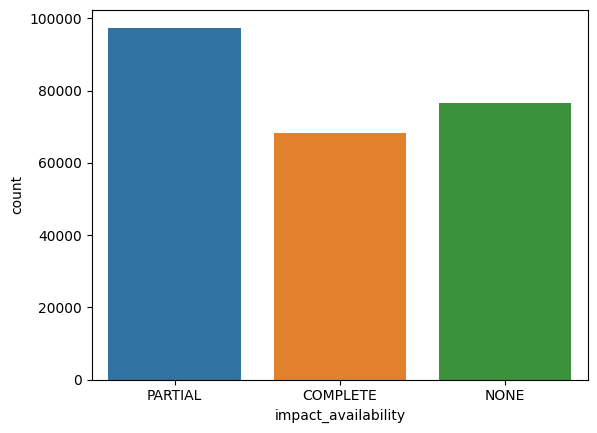

In [22]:
sns.countplot(data = df, x = 'impact_availability')

In [23]:
nulos = df['impact_availability'].isnull().sum()

print('cantidad de nulos: ', nulos)

cantidad de nulos:  9376


<Axes: xlabel='impact_confidentiality', ylabel='count'>

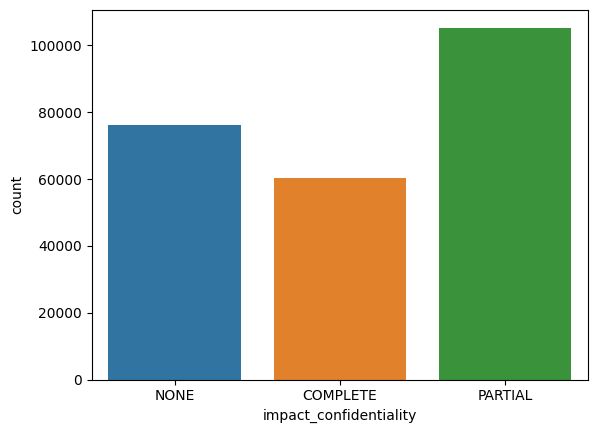

In [24]:
sns.countplot(data = df, x = 'impact_confidentiality')

Como vemos en los dos últimos gráficos de barras ambos tienen los datos distribuidos de una manera interesante, sin embargo, notamos que son bastante parecidos por lo que pueden estar correlacionados, saquemos una tabla de contingencia

In [25]:
tabla_contingencia = pd.crosstab(df['impact_availability'], df['impact_confidentiality'])

print(tabla_contingencia)

impact_confidentiality  COMPLETE   NONE  PARTIAL
impact_availability                             
COMPLETE                   56709  10687      740
NONE                        3639  34429    38358
PARTIAL                       52  31149    66241


Observamos que los valores de la diagonal principal son mucho más elevados que los triangulares superiores e inferiores, por lo que eliminar una de estas variables nos ayudará a reducir la dimensión del problema. Así nos quedaremos con impact_availability.

Nota: Existe una métrica más formal para medir este nivel de correlación de una manera más efectiva conocida como coeficiente de contingencia (Cramér's V)

<Axes: xlabel='impact_integrity', ylabel='count'>

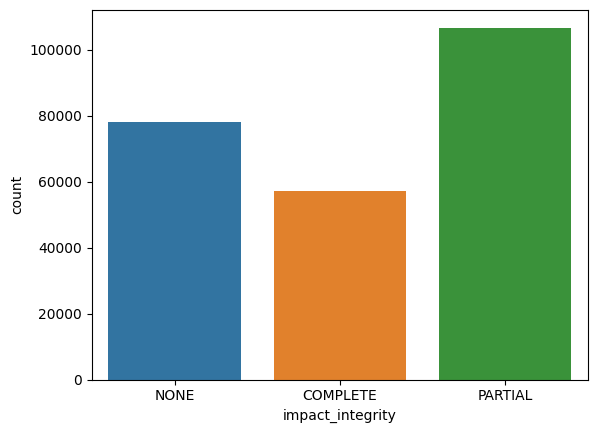

In [26]:
sns.countplot(data = df, x = 'impact_integrity')

In [27]:
tabla_contingencia = pd.crosstab(df['impact_availability'], df['impact_integrity'])

print(tabla_contingencia)

impact_integrity     COMPLETE   NONE  PARTIAL
impact_availability                          
COMPLETE                56856  10472      808
NONE                      365  37382    38679
PARTIAL                    23  30265    67154


Análogamente que en el caso anterior, la tabla de contingencia nos muestra una diagonal con valores elevados, por lo que descartaremos 'impact_integrity'

In [28]:
len(df['cwe_name'].unique())

170

La columna cwe_name podría ser interesante, sin embargo nos introduce 170 caracteristicas nuevas, por lo que para un modelo simplificado con las categorías sería un poco complicado trabajar, para el proyecto será descartada, tampoco consideraremos relevantes en este trabajo las columnas de fechas aunque podría llegar a ser interesante encontrar segmentadores de años en los datos de las vulnerabilidades, y ver por ejemplo si hay grupos con vulnerabilidades muy peligrosas en los años más recientes.

En resumen tenemos entonces que las caracteristicas que usaremos en este trabajo son:

- cvss
- access_complexity
- impact_availability



In [29]:
features = ['cvss','access_complexity','impact_availability']

df.isna().sum()

Unnamed: 0                   0
mod_date                     0
pub_date                     0
cvss                         0
cwe_code                     0
cwe_name                     0
summary                      0
access_authentication     9376
access_complexity         9376
access_vector             9376
impact_availability       9376
impact_confidentiality    9376
impact_integrity          9376
vulnerable_product          42
vendor                      42
dtype: int64

In [30]:
df[df['impact_availability'].isna()]

,Unnamed: 0,mod_date,pub_date,cvss,cwe_code,cwe_name,summary,access_authentication,access_complexity,access_vector,impact_availability,impact_confidentiality,impact_integrity,vulnerable_product,vendor
2103,CVE-2005-2351,2019-11-01 19:22:00,2019-11-01 19:15:00,2.1,668,Exposure of Resource to Wrong Sphere,Mutt before 1.5.20 patch 7 allows an attacker ...,NaN,NaN,NaN,NaN,NaN,NaN,mutt,mutt
2104,CVE-2005-2351,2019-11-01 19:22:00,2019-11-01 19:15:00,2.1,668,Exposure of Resource to Wrong Sphere,Mutt before 1.5.20 patch 7 allows an attacker ...,NaN,NaN,NaN,NaN,NaN,NaN,mutt,debian
2105,CVE-2005-2351,2019-11-01 19:22:00,2019-11-01 19:15:00,2.1,668,Exposure of Resource to Wrong Sphere,Mutt before 1.5.20 patch 7 allows an attacker ...,NaN,NaN,NaN,NaN,NaN,NaN,debian_linux,mutt
2106,CVE-2005-2351,2019-11-01 19:22:00,2019-11-01 19:15:00,2.1,668,Exposure of Resource to Wrong Sphere,Mutt before 1.5.20 patch 7 allows an attacker ...,NaN,NaN,NaN,NaN,NaN,NaN,debian_linux,debian
4188,CVE-2005-4890,2019-11-04 19:56:00,2019-11-04 19:15:00,7.2,20,Improper Input Validation,There is a possible tty hijacking in shadow 4....,NaN,NaN,NaN,NaN,NaN,NaN,shadow,debian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248715,CVE-2019-8246,2019-11-14 16:53:00,2019-11-14 16:15:00,10.0,787,Out-of-bounds Write,Adobe Media Encoder versions 13.1 and earlier ...,NaN,NaN,NaN,NaN,NaN,NaN,media_encoder,adobe
248716,CVE-2019-8247,2019-11-14 16:53:00,2019-11-14 16:15:00,10.0,119,Improper Restriction of Operations within the...,Adobe Illustrator CC versions 23.1 and earlier...,NaN,NaN,NaN,NaN,NaN,NaN,illustrator_cc,adobe
248717,CVE-2019-8248,2019-11-14 16:53:00,2019-11-14 16:15:00,10.0,119,Improper Restriction of Operations within the...,Adobe Illustrator CC versions 23.1 and earlier...,NaN,NaN,NaN,NaN,NaN,NaN,illustrator_cc,adobe
249865,CVE-2019-9466,2019-11-13 20:22:00,2019-11-13 20:15:00,7.5,20,Improper Input Validation,"In the Broadcom Wi-Fi driver, there is a possi...",NaN,NaN,NaN,NaN,NaN,NaN,android,google


Debemos limpiar nuestro conjunto de datos de los valores faltantes,sospechamos de que todos los nan de las variables que usaremos como features coinciden por lo que no aportarán mucha información si las eliminamos, recordemos que tenemos en ambos casos de las columnas categóricas 9373 datos, por lo que si eliminamos estos registros estaremos eliminando $\frac{9373}{251380}=0,037%$ es decir, $3,7$ % de los datos, lo cual es un porcentaje de los datos bastante pequeño

In [31]:
df_features = df[['cvss','access_complexity','impact_availability']]

In [32]:
df_features.dropna(subset=['access_complexity'], inplace=True)

<ipython-input-32-16bdbf047241>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features.dropna(subset=['access_complexity'], inplace=True)


In [33]:
df_features.shape

(242004, 3)

In [34]:
df_features.isnull().sum()

cvss                   0
access_complexity      0
impact_availability    0
dtype: int64

Ya no tenemos valores faltantes y tenemos ahora un conjunto de datos con 242004 registros, sigue siendo un buen número de información. Ya tenemos nuestro dataset limpio y isto para el clustering

# **Diseñando Algoritmo de Clustering**

Lo primero que tenemos que hacer en esta fase es elegir la cantidad de clusters o grupos. Para esto utilizaremos un proceso conocido como el método del codo el cuál consiste en minimizar la variacion dentro de cada cluster. Entonces el k óptimo es un valor tal que los datos agrupados son lo más homogeneos posible. Este método es conocido como el método del codo porque la forma del gráfico es similar a un 'brazo' y el análisis cualitativo nos permitirá elegir el valor de k más similar a un 'codo' de una persona

In [35]:
#df_features

1
2
3
4
5
6
7


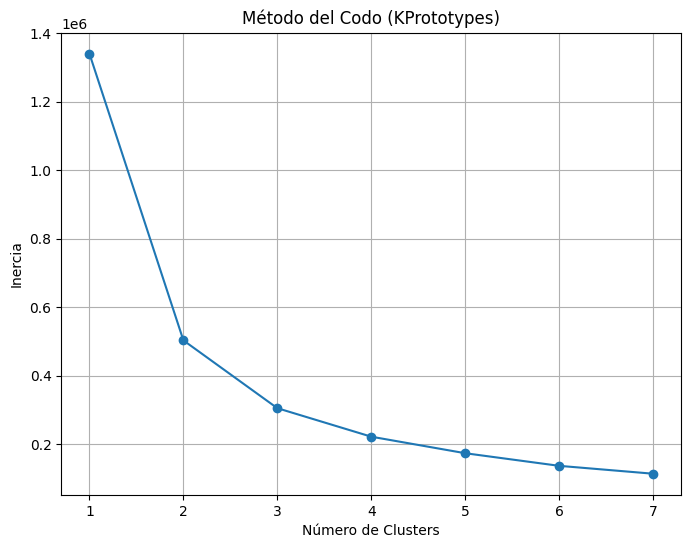

In [36]:
# No necesitamos escalar nuestra variable numérica dado que no tenemos más variables numéricas con las que comparar.
#scaler = StandardScaler()
#df_features['cvss'] = scaler.fit_transform(df_features['cvss']values.reshape(-1, 1))

# Definimos un rango de número de clusters para probar
num_clusters_range = range(1, 8)

# Calcular la inercia para diferentes números de clusters
inercia = []
i=1
for num_clusters in num_clusters_range:
    try:
        kproto = KPrototypes(n_clusters=num_clusters, init='Cao')
        X = df_features[['cvss','access_complexity','impact_availability']].values
        clusters = kproto.fit_predict(X, categorical=[1, 2])
        inercia.append(kproto.cost_)
    except Exception as e:
        print(f"Error con {num_clusters} clusters: {str(e)}")

    print(i)
    i+=1

# Crear un gráfico del método del codo
plt.figure(figsize=(8, 6))
plt.plot(num_clusters_range, inercia, marker='o')
plt.title('Método del Codo (KPrototypes)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.xticks(num_clusters_range)
plt.grid(True)
plt.show()

Nota: Para elegir $k$ debemos recordar que tenemos que elegir el valor a partir del cual haya una variación pequeña en la inercia respecto al número de clusters. este valor debe tomarse de tal manera que los datos sean lo más homogeneos posibles en los cluster y no tan grande como para no tener exceso de clusters que no aproten información nueva y relevante por grupo.

La cantidad optima de clusters es $k=3$

In [37]:
# Iniciemos el algoritmo entonces con k=3
kproto = KPrototypes(n_clusters=3, init='Cao')
X = df_features[['cvss','access_complexity','impact_availability']].values
clusters = kproto.fit_predict(X, categorical=[1, 2])
inercia.append(kproto.cost_)

En el código anterior inicializamos los centroides correspondientes a las categorías aleatoriamente, existen otros métodos como Huang que inicializa las variables categóricas teniendo en cuenta las frecuencias y random inicializa todo de forma aleatoria, random es útil para probar la estabilidad de los cluster

In [38]:
df_features['Cluster'] = clusters

<ipython-input-38-a15eeea2cf5a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['Cluster'] = clusters


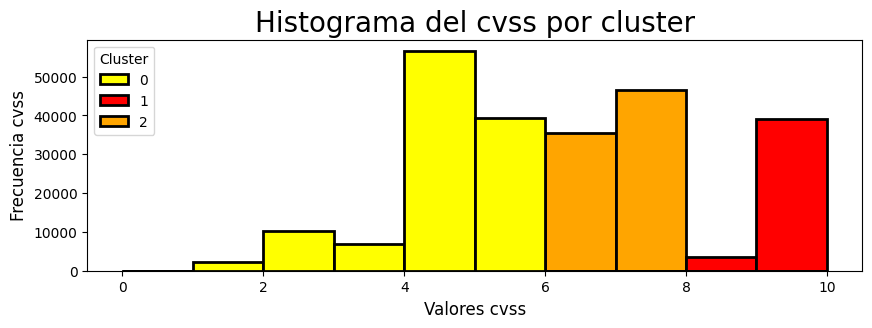

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame llamado "Data" con las columnas "impact_availability" y "clusters"
# y "clusters" contiene los valores 0, 1 y 2

# Gráfico countplot por impact_availability
plt.figure(figsize=(10, 3))
sns.histplot(data = df_features , x = 'cvss',bins=10,hue='Cluster',palette = ["yellow", "red", "orange"],alpha=1,
             linewidth=2)
#sns.countplot(data=Data, x='impact_availability', hue='clusters')
plt.title('Histograma del cvss por cluster',size=20)
plt.xlabel('Valores cvss',size=12)
plt.ylabel('Frecuencia cvss',size=12)
plt.show()

Debemos recordar que los números en los clusters son etiquetas nominales, no ordinales, por tanto aquí podemos empezar a interpretar la agrupación.

$k=1$ es un grupo que contiene los puntajes más bajos de cvss

$k=0$ es un grupo que contiene los puntajes intermedios del cvss

$k=2$ es un grupo que contiene los puntajes más altos de cvss, correspondiente a las vulreabilidades más riesgosas

In [52]:
# media de los datos numericos por cluster
df_features.groupby(['Cluster']).mean()

<ipython-input-52-a1f8531a04c1>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_features.groupby(['Cluster']).mean()


,cvss
Cluster,
0,4.306382
1,9.519743
2,7.102025


In [53]:
df_features.groupby(['Cluster']).agg(lambda x: pd.Series.mode(x).iat[0])[['access_complexity','impact_availability']]

,access_complexity,impact_availability
Cluster,,
0,LOW,NONE
1,LOW,COMPLETE
2,LOW,PARTIAL


Si observamos las modas de las categorías numéricas vemos que los tres clusters comparten lamoda `LOW` para `acces_complexity` y en la variable `impact_availability` cada cluster tiene una moda diferente.

Notamos que se corresponden muy bien dado que: el cluster `1` contiene los puntajes de `cvss` más bajos y el impacto en la disponibilidad es `NONE`, el cluster `0` contiene los puntajes de `cvss` más intermedios y el impacto en la disponibilidad es `PARTIAL`, el cluster `2` contiene los puntajes de `cvss` más altos y el impacto en la disponibilidad es `COMPLETE`,

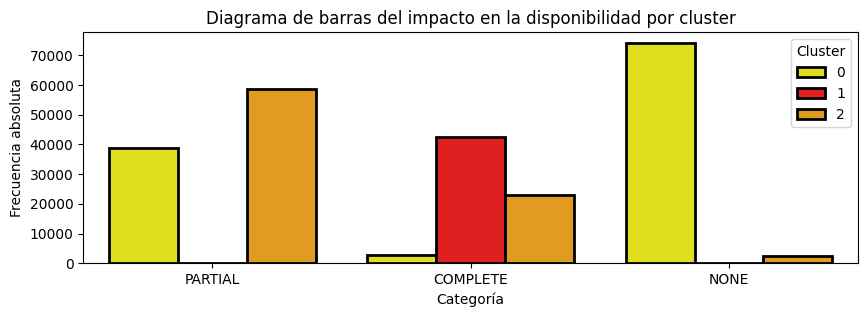

In [54]:
plt.figure(figsize=(10, 3))
sns.countplot(data=df_features, x='impact_availability', hue='Cluster',palette = ["yellow", "red", "orange"],
              edgecolor='black',linewidth=2)
plt.title('Diagrama de barras del impacto en la disponibilidad por cluster')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia absoluta')
plt.show()

Es notorio cómo predomina en la disponibilidad del servicio en la categoría `Complete` el cluster 2 que es el correspondiente al que tiene los puntajes más altos de `cvss`. Análogamente en la disponibilidad del servicio de manera en la categoría `PARTIAL` predomina el cluster 0 correspondientes a valores medios para `cvss` y de la misma manera inferimos para la categoría `NONE` correspondiente a valores bajos para `cvss`

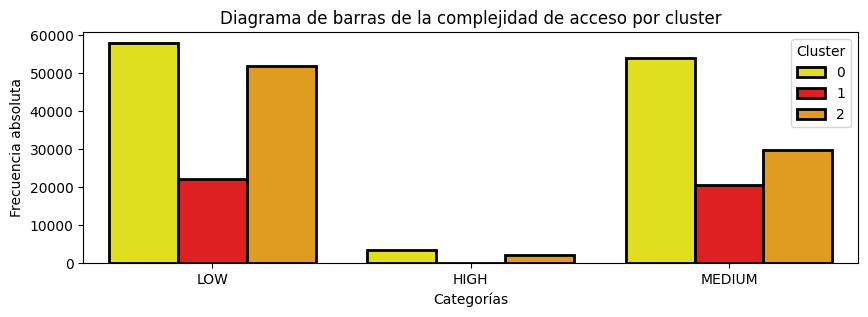

In [55]:
plt.figure(figsize=(10, 3))
sns.countplot(data=df_features, x='access_complexity', hue='Cluster',palette = ["yellow", "red", "orange"],
              edgecolor='black',linewidth=2)
plt.title('Diagrama de barras de la complejidad de acceso por cluster')
plt.xlabel('Categorías')
plt.ylabel('Frecuencia absoluta')
plt.show()

Intuitivamente antes de realizar el proceso esperaba que las agrupaciones se realizaran con el cluster 2 en `HIGH` dado que la complejidad en el acceso se espera que sea complejo para vulnerabilidades peligrosas, pero vemos que algunas con bajo puntaje de `cvss` se lograron filtrar a través de complejidad de acceso `HIGH`. Por otro lado se distribuyen para `LOW` y para `MEDIUM` de una manera muy proporcional las vulnerabilidades más peligrosas y también las más leves

Una validación cualitativa de los Clusters permite dar una idea de qué tan bien o mal están agrupados, esto debido a que no hay una métrica sencilla que pueda trabajar con datos mixtos. Es por esta razón que hemos evaluado la calidad de los clusters con gráficos de barras. Podemos evaluar la homogeneidad de los clusters con la métrica `silhouette_avg` para la variable numérica, esta métrica se evalúa entre -1 y 1, donde -1 es mala calidad, 0 es calidad muy regular y 1 es muy buena calidad de los clusters. Su funcionamiento consiste en tomar una distancia euclidea entre un punto y su cluster, luego entre el mismo punto y un cluster próximo para luego comparar estas distancias y ver que tan diferentes son, el resultado negativo se obtiene cuando las distancias euclideas del dato en su cluster es mayor que la distancia del cluster más cercano

In [45]:
from sklearn.metrics import silhouette_score
X_numeric = df_features['cvss'].values.reshape(-1, 1)
# Supongamos que 'clusters' contiene las etiquetas de cluster asignadas por tu algoritmo K-Prototypes
silhouette_avg = silhouette_score(X_numeric, clusters)
print("Silhouette Score (variable numérica):", silhouette_avg)


Silhouette Score (variable numérica): 0.7192702690710379


Como vemos obtenemos buena calidad de los clusters para nuestra variable numérica `cvss`